In [1]:
import casadi as ca
import numpy as np
import math
import control as ct
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Cascaded PID implementation of QuadCopter Control
We use a NED frame with **intrinsic** Y-P-R rotations ${}^{I}R_{B}=R_{\psi}R_{\theta}R_{\phi}$ with body frame and inertial frames aligned when there is **no rotation**.

$$
\begin{align}
m\ddot{X} &= -F(\cos{\phi}\sin{\theta}\cos{\psi}+\sin{\phi}\sin{\psi}) \\
m\ddot{Y} &= -F(\cos{\phi}\sin{\theta}\sin{\psi}-\sin{\phi}\cos{\psi}) \\
m\ddot{Z} &= -F(\cos{\phi}\cos{\theta})+mg \\
I_{x}\ddot{\phi} &= T_{x}l+\dot{\theta}\dot{\psi}(I_{y}-I_{z}) \\
I_{y}\ddot{\theta} &= T_{y}l+\dot{\psi}\dot{\phi}(I_{z}-I_{x}) \\
I_{z}\ddot{\psi} &= T_{z}l+\dot{\phi}\dot{\theta}(I_{x}-I_{y}) \\
F & = F_1 + F_2 + F_3 + F_4
\end{align}
$$

We first use 3 PID controllers to direct the roll/pitch/yaw rates to 0

In [2]:
x = ca.SX.sym("x", 12)
u = ca.SX.sym("u", 4)

#m = 1
m = 2.43  # kg
g = 9.81  # m/s^2
#Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
#Ix, Iy, Iz = 0.0035, 0.0035, 0.005  # kg m^2
Ix, Iy, Iz = 0.008, 0.015, 0.017  # kg m^2
l = 0.2  # m (this drops out when controlling via torques)
dt=0.01 ## Simulate step at 100Hz

parms = {"Q": np.eye(12), "R": np.eye(4), "N": 10, "Qf": np.eye(12), "dynamic": True}

# non linear dynamics
x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

dx_x = x_dx
dx_y = x_dy
dx_z = x_dz
dx_phi = x_dphi
dx_theta = x_dtheta
dx_psi = x_dpsi
dx_dx = -(u_F/m) * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
dx_dy = -(u_F/m) * (ca.cos(x_phi)*ca.sin(x_theta)*ca.sin(x_psi) - ca.sin(x_phi)*ca.cos(x_psi))
dx_dz = -(u_F/m) * (ca.cos(x_phi) * ca.cos(x_theta)) + g
dx_dphi = 1/Ix * (u_Tx + x_dtheta * x_dpsi*(Iy - Iz))
dx_dtheta = 1/Iy * (u_Ty + x_dpsi*x_dphi*(Iz - Ix))
dx_dpsi = 1/Iz * (u_Tz + x_dphi*x_dtheta*(Ix-Iy))

x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

## Apply 25N of force for 10 seconds
out = [0, 0, -20, 0.2, 0.2, 0, 0, 0, 0, 0, 0, 0]
u_in = [25, 0, 0, 0]
for i in range(0,1000):
    out = dynamics(out, u_in)
print(f"State after 10s: {out}")

assert(out[0]<0) ## Negative x-coordinate with +ve pitch
assert(out[1]>0) ## Positive y-coordinate with +ve roll
assert(out[2]<0) ## Negative z-coordinate with positive net Force in NED frame

## Linearization
x_operating = np.zeros((12, 1))
u_operating = np.array([m*g, 0, 0, 0]).reshape((-1, 1))  # hovering (mg 0 0 0)

A = ca.Function("A", [x, u], [ca.jacobian(f, x)])(x_operating, u_operating)
B = ca.Function("B", [x, u], [ca.jacobian(f, u)])(x_operating, u_operating)
C = np.eye(12)
D = np.zeros((12, 4))

#make numerical matrices and cast into numpy array
A = np.array(ca.DM(A))
B = np.array(ca.DM(B))

lin_ss_cont = ct.ss(A,B,C,D)
lin_ss_disc = ct.c2d(lin_ss_cont,dt,method='zoh')

State after 10s: [-100.059, 102.094, -23.5964, 0.2, 0.2, 0, -20.0318, 20.4392, -0.72001, 0, 0, 0]


In [116]:
class PID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd

        self.integral = 0.0
        self.prev_error = 0.0

    def __call__(self, target, measurement, dt):
        error = target - measurement

        # Integral term
        self.integral += error * dt

        # Derivative term (protect against dt=0)
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0

        # PID output
        output = self.kp * error + self.ki * self.integral + self.kd * derivative

        # Store error for next step
        self.prev_error = error

        return output

    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0

rate_roll = PID(0.5,0.1,0)
rate_pitch = PID(0.5,0.1,0)
rate_yaw = PID(0.5,0.1,0)

error_roll = PID(5,0.1,0)
error_pitch = PID(5,0.1,0)
error_yaw = PID(5,0.1,0)

controller_array = [rate_roll, rate_pitch, rate_yaw, error_roll, error_pitch, error_yaw]

In [117]:
## Simulation Setup
iterations=500

dt = 0.01
x_bag = np.zeros((12, iterations))
time = np.linspace(0,1,100)

temp_x = [0, 0, 10, 0.1, 0, -0.1, 0, 0, 0, 0.3, -0.3, -0.1]
temp_u = [0, 0, 0, 0]

## Control variables

# Destination (NED frame, metres)
target_x = 50
target_y = 50
target_z = -20 ## Indicates 20 metres above "ground" or "0 alt"
target_yaw = 0 ## No yawing required for our waypoint controller

## Reset all PID controllers
for c in controller_array:
    c.reset()

## Intermediate variables that we want to plot
ctx = {
    'c_roll_out': [],
    'c_pitch_out': [],
    'c_yaw_out': [],
    'c_throttle_out': [],
    'mot_0': [],
    'mot_1': [],
    'mot_2': [],
    'mot_3': [],
    'u_force': [],
    'u_rtorque': [],
    'u_ptorque': [],
    'u_ytorque': []
}

desired_roll = 0
desired_pitch = 0

## 1 second simulation
outer = True
for j in range(0,iterations):
    if j%5==0 and outer:
        ## Run outer loop
        roll_rate_target = error_roll(0, temp_x[3], 0.01)
        pitch_rate_target = error_pitch(0, temp_x[4], 0.01)
        yaw_rate_target = error_yaw(0, temp_x[5], 0.01)
    elif not outer:
        roll_rate_target = 0
        pitch_rate_target = 0
        yaw_rate_target = 0
        
    rroll_current = temp_x[9]
    rpitch_current = temp_x[10]
    ryaw_current = temp_x[11]
    
    rt = rate_roll(roll_rate_target, rroll_current, 0.01)
    pt = rate_pitch(pitch_rate_target, rpitch_current, 0.01) 
    yt = rate_yaw(yaw_rate_target, ryaw_current, 0.01)

    temp_u = [m*g, rt, pt, yt]
    
    ## Constrain force between [0,20] : 0 is no throttle and 20 is full throttle
    if temp_u[0]<0:
        temp_u[0]=0
    elif temp_u[0]>50:
        temp_u[0]=50
    
    # Store intermediate variables
    ctx['u_force'].append(temp_u[0])
    ctx['u_rtorque'].append(temp_u[1])
    ctx['u_ptorque'].append(temp_u[2])
    ctx['u_ytorque'].append(temp_u[3])

    # Feed dynamics
    temp_x = dynamics(temp_x, temp_u).full()

    # Wrap roll/pitch/yaw
    ## TODO

    # Record output for plotting
    x_bag[:, j] = temp_x.reshape((12,))
    temp_x = temp_x.reshape((12,))

print(temp_x, temp_u)

[ 1.16100623e-01  8.68476976e-01  1.00275059e+01 -1.47825120e-04
  1.48218386e-04  1.20182210e-04  1.89219886e-02  1.75260504e-01
  5.59993752e-03  1.51344146e-05 -3.07158744e-05 -8.90011543e-06] [23.838300000000004, np.float64(4.923962204016977e-07), np.float64(-1.2776633352161774e-06), np.float64(-3.6204573672626297e-07)]


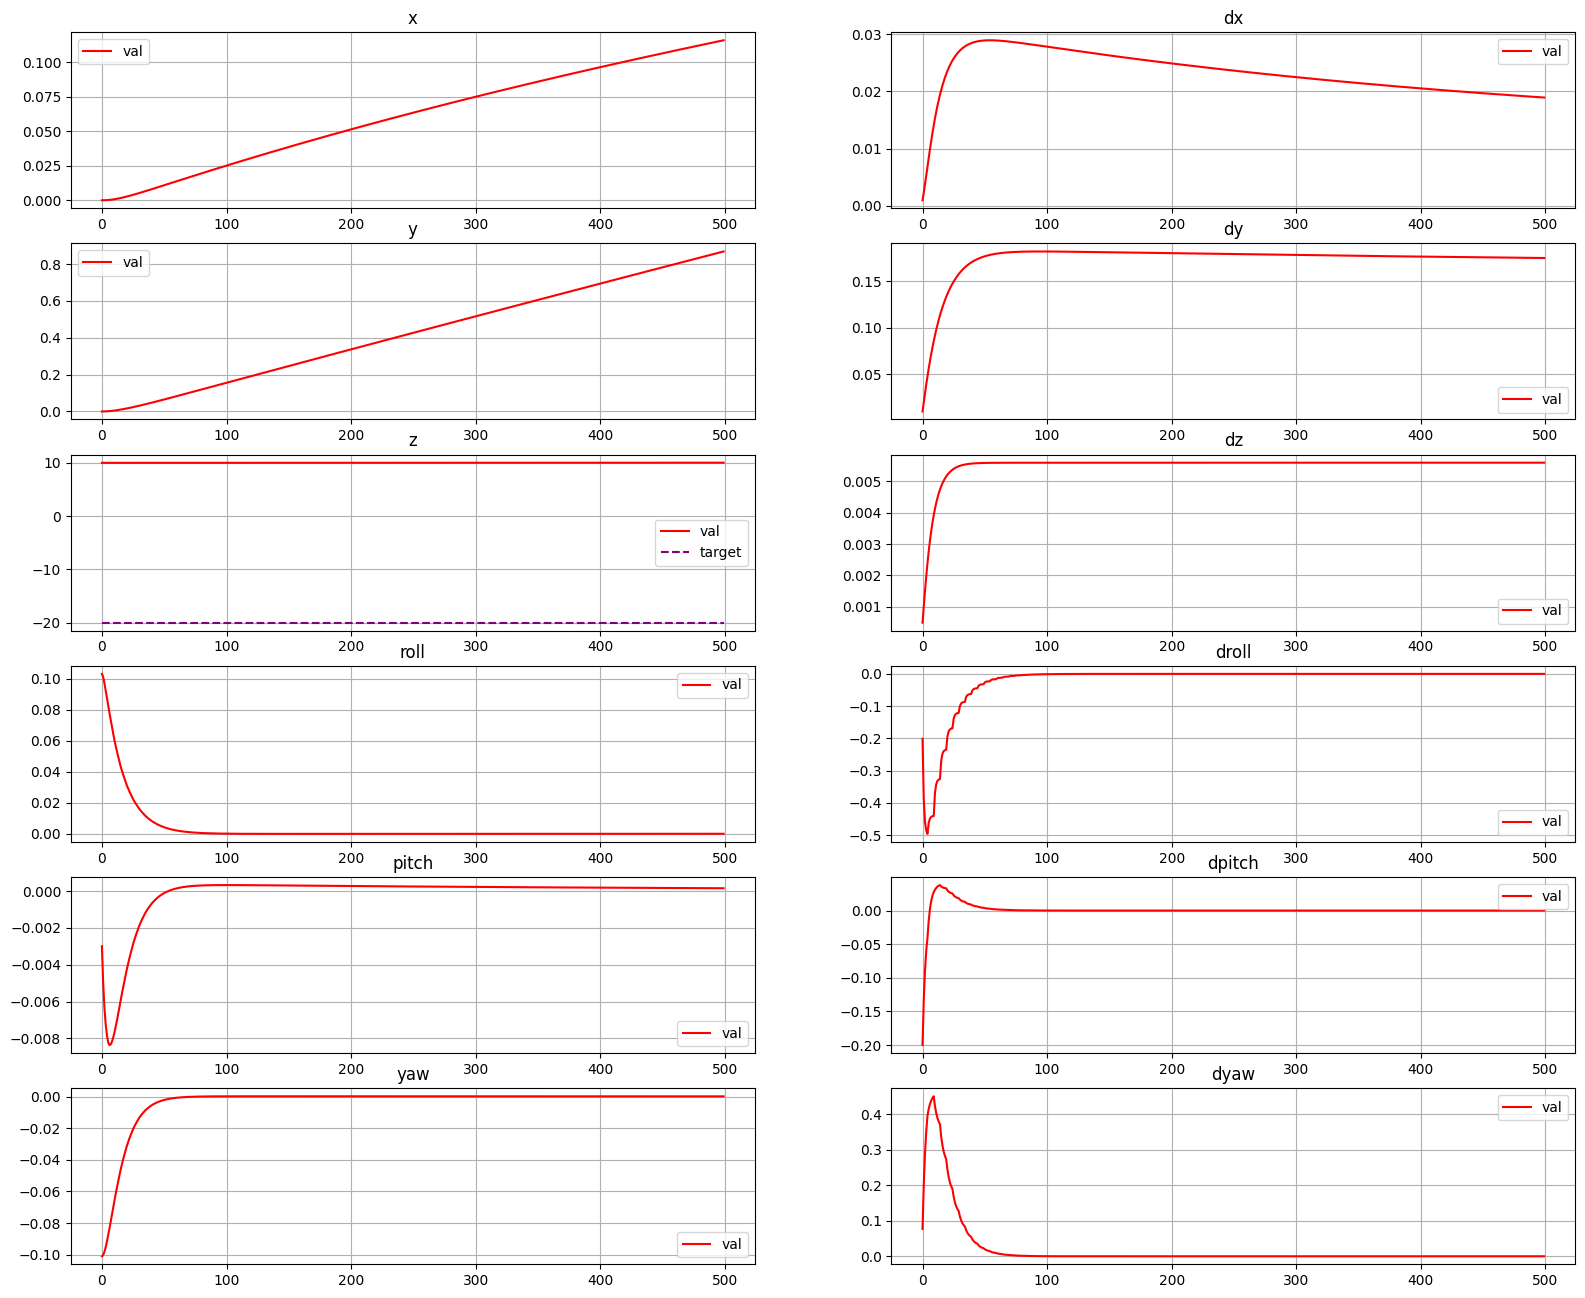

In [118]:
# Visualisation - State Variables
fig = plt.figure(figsize=(30, 16))
gs = GridSpec(6, 3, figure=fig)

for i,title in enumerate(['x','y','z','roll','pitch','yaw','dx','dy','dz','droll','dpitch','dyaw']):
    ax = fig.add_subplot(gs[i%6,i//6])
    t = range(0,x_bag[i,:].shape[0])
    ax.plot(t, x_bag[i,:], color='red', label='val')
    if title=='z':
        ax.plot(t, len(t)*[-20], color='purple', linestyle='--', label='target')
    ax.set_title(title)
    ax.grid()
    ax.legend()

plt.show()

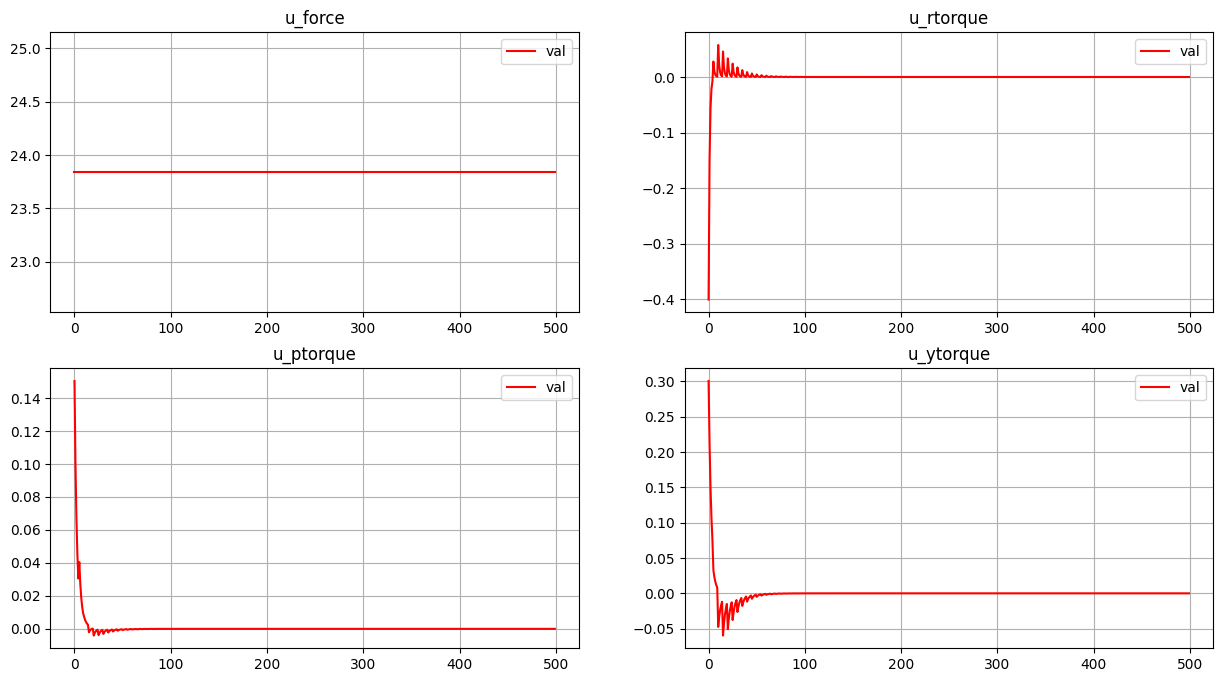

In [112]:
# Visualisation - State Variables
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(2, 2, figure=fig)

for i,title in enumerate(['u_force', 'u_rtorque', 'u_ptorque', 'u_ytorque']):
    ax = fig.add_subplot(gs[i//2, i%2])
    t = range(0,len(ctx[title]))
    ax.plot(t, ctx[title], color='red', label='val')
    if title=='z':
        ax.plot(t, len(t)*[-20], color='purple', linestyle='--', label='target')
    ax.set_title(title)
    ax.grid()
    ax.legend()

plt.show()